# Time Series Analyisis Using DeepLearning

__Why Deep Learning?__


    Missing data in the observations is not supported in classic models
    
    Focused on onestep forecasts
    
    Univariate analysis is focused where as in real time we might be needing various features to calculate predictions
    
    Looking for linear relationships in data
    
    Number of lag observations provided as input, must be diagnosed and specified.

__Advantages with NN :__

    Robust to noise

    Non linear

    Multivariate inputs

    Multistep forecasts
    
__Note__: _Models here aren't robust for the same you might be getting different result in different runs. I would be happy to see you make them robust :) _

In [1]:
#All imports

import numpy as np
import pandas as pd
import math
from math import sqrt
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN,LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [3]:
house_data = pd.read_csv("All-Transactions House Price Index.csv",index_col='Date', parse_dates=['Date'])
house_data.columns

Index(['Value'], dtype='object')

In [4]:
#“iloc” in pandas is used to select rows and columns by number [rows,columns]
# train,test split
train = house_data[:'2014'].iloc[:,:].values #100 Samples
test = house_data['2015':].iloc[:,:].values #10 Samples

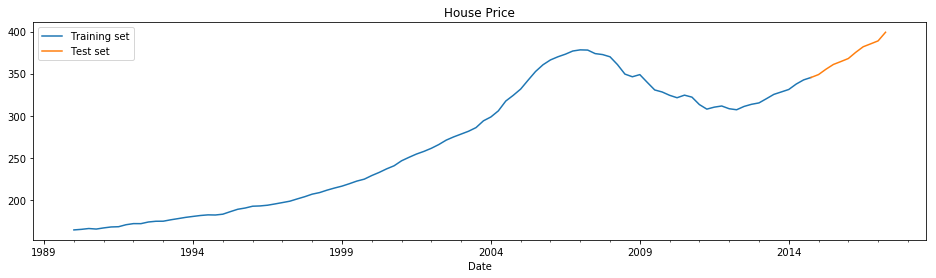

In [5]:
#Lets visualize the data
house_data['Value'][:100].plot(figsize=(16,4),legend=True)
house_data['Value'][99:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('House Price')
plt.show()

In [6]:
#Scaling data
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train)

In [7]:
#train_data_scaled

We feed in the previous value window to predict the next value. For this we need to split the sequence into samples

In [35]:
time_steps = 10

In [8]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the ending index
        end_index = i + n_steps
        # checking the length
        if end_index > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_index], sequence[end_index]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
#For each element in value we have 15 previous values helping to predict it
X_train,y_train = split_sequence(train_data_scaled,time_steps)

In [10]:
#Check the data
#X_train[0],y_train[0]

In [11]:
X_train.shape

(90, 10, 1)

In [12]:
X_train[0]

array([[ 0.        ],
       [ 0.00312996],
       [ 0.00775484],
       [ 0.00476502],
       [ 0.01116509],
       [ 0.01639727],
       [ 0.01779875],
       [ 0.02882369],
       [ 0.03499019],
       [ 0.03480333]])

In [13]:
# Reshape Subsequences
# Shape your data to (NumberOfSamples, TimeSteps, Features)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [14]:
X_train[0]

array([[ 0.        ],
       [ 0.00312996],
       [ 0.00775484],
       [ 0.00476502],
       [ 0.01116509],
       [ 0.01639727],
       [ 0.01779875],
       [ 0.02882369],
       [ 0.03499019],
       [ 0.03480333]])

In [15]:
X_train.shape[0]

90

In [16]:
X_train.shape[1]

10

__How RNN works?__

![](LSTM3-SimpleRNN.png)

In [17]:
model = Sequential()
model.add(SimpleRNN(70, input_shape = (X_train.shape[1],
    X_train.shape[2]), activation = 'relu'))
# Dropout is a regularization method which has the effect of reducing overfitting and improving model performance.
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])
model.fit(X_train, y_train, 
    epochs=50, batch_size=25, 
    validation_split = 0.20)

Train on 72 samples, validate on 18 samples
Epoch 1/50
72/72 [==============================] - 0s - loss: 0.3258 - mean_squared_error: 0.3258 - val_loss: 0.5384 - val_mean_squared_error: 0.5384
Epoch 2/50
72/72 [==============================] - 0s - loss: 0.3070 - mean_squared_error: 0.3070 - val_loss: 0.4855 - val_mean_squared_error: 0.4855
Epoch 3/50
72/72 [==============================] - 0s - loss: 0.2653 - mean_squared_error: 0.2653 - val_loss: 0.3651 - val_mean_squared_error: 0.3651
Epoch 4/50
72/72 [==============================] - 0s - loss: 0.1943 - mean_squared_error: 0.1943 - val_loss: 0.2582 - val_mean_squared_error: 0.2582
Epoch 5/50
72/72 [==============================] - 0s - loss: 0.1398 - mean_squared_error: 0.1398 - val_loss: 0.1628 - val_mean_squared_error: 0.1628

In [18]:
dataset_total = pd.concat((house_data[:'2014'],house_data['2015':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test) - time_steps:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [19]:
len(inputs)

20

In [20]:
# Preparing X_test and predicting the prices
X_test = []

for i in range(time_steps,time_steps+10):
    X_test.append(inputs[i-time_steps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)

In [21]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Value')
    plt.plot(predicted, color='blue',label='Predicted Value')
    plt.title('House Value Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [22]:
rmse = sqrt(mean_squared_error(test, predicted_values))
print('Test RMSE: %.3f' % (rmse))

Test RMSE: 5.976


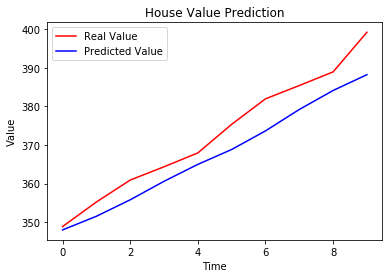

In [23]:
plot_predictions(test,predicted_values)

__How LSTM works?__

![](LSTM3-chain.png)

In [24]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape = (X_train.shape[1],1), return_sequences=True, activation = 'relu'))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(50,activation='relu'))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1))
lstm_model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])
lstm_model.fit(X_train, y_train, 
    epochs=50, batch_size=25, 
    validation_split = 0.20)

Train on 72 samples, validate on 18 samples
Epoch 1/50
72/72 [==============================] - 1s - loss: 0.3261 - mean_squared_error: 0.3261 - val_loss: 0.5081 - val_mean_squared_error: 0.5081
Epoch 2/50
72/72 [==============================] - 0s - loss: 0.2991 - mean_squared_error: 0.2991 - val_loss: 0.4578 - val_mean_squared_error: 0.4578
Epoch 3/50
72/72 [==============================] - 0s - loss: 0.2670 - mean_squared_error: 0.2670 - val_loss: 0.3965 - val_mean_squared_error: 0.3965
Epoch 4/50
72/72 [==============================] - 0s - loss: 0.2322 - mean_squared_error: 

In [25]:
#Why is Return Sequences?

In [26]:
predicted_values = lstm_model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)

In [27]:
rmse = sqrt(mean_squared_error(test, predicted_values))
print('Test RMSE: %.3f' % (rmse))

Test RMSE: 26.167


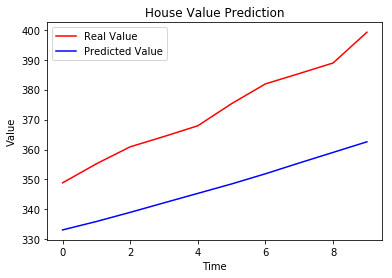

In [28]:
plot_predictions(test,predicted_values)

__MULTI LAYER PERCEPTRON__

![](mlp_ex.png)


__MLP Things to look out for:__

The input dimension for each sample is specified in the input_dim argument on the definition of first hidden layer.
Technically, the model will view each time step as a _separate feature instead of separate time steps._ which tells us the inability to handle temporal dependencies.

__input here:__
[samples, features]




In [29]:
X_train_mlp = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]))

In [30]:
mlp_model = Sequential()
mlp_model.add(Dense(30, activation='sigmoid', input_dim=X_train_mlp.shape[1]))
mlp_model.add(Dense(1))
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
mlp_model.fit(X_train_mlp,y_train, epochs=100, batch_size=25, 
    validation_split = 0.20)

Train on 72 samples, validate on 18 samples
Epoch 1/100
72/72 [==============================] - 0s - loss: 3.5098 - val_loss: 4.2228
Epoch 2/100
72/72 [==============================] - 0s - loss: 3.2401 - val_loss: 3.8773
Epoch 3/100
72/72 [==============================] - 0s - loss: 2.9820 - val_loss: 3.5504
Epoch 4/100
72/72 [==============================] - 0s - loss: 2.7441 - val_loss: 3.2402
Epoch 5/100
72/72 [==============================] - 0s - loss: 2.5131 - val_loss: 2.9492
Epoch 6/100
72/72 [==============================] - 0s - loss: 2.2941 - val_loss: 2.6774
Epoch 7/100
72/72 [==============================] - 0s - loss: 2.0935 - val_loss: 2.4230

In [32]:
X_test_mlp = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]))
predicted_values = mlp_model.predict(X_test_mlp)
predicted_values = scaler.inverse_transform(predicted_values)

In [33]:
rmse = sqrt(mean_squared_error(test, predicted_values))
print('Test RMSE: %.3f' % (rmse))

Test RMSE: 14.698


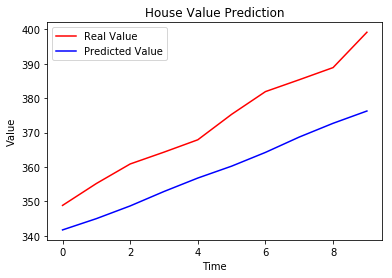

In [34]:
plot_predictions(test,predicted_values)

# Things to remember

Contiguous. Observations are made uniform over time.
Discontiguous. Observations are not uniform over time.

Static. A forecast model is fit once and used to make predictions.
Dynamic. A forecast model is fit on newly available data prior to each prediction.

One-Step: Forecast the next time step.
Multi-Step: Forecast more than one future time steps.

Univariate and Multivariate Inputs: One or multiple input variables measured over time.
Univariate and Multivariate Outputs: One or multiple output variables to be predicted.

Unstructured: No obvious systematic time-dependent pattern in a time series variable.
Structured: Systematic time-dependent patterns in a time series variable (e.g. trend and/or seasonality).

Endogenous: Input variables that are influenced by other variables in the system and on which the output variable depends.
Exogenous: Input variables that are not influenced by other variables in the system and on which the output variable depends.

Inputs: Historical data provided to the model in order to make a single forecast.
Outputs: Prediction or forecast for a future time step beyond the data provided as input.



In [348]:
# When do you think we can go for MLP, RNN and LSTM ?